In [1]:
import tensorflow as tf
import urllib
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras import layers
from tensorflow.keras import Model

In [2]:
# 사전훈련된 가중치 불러오기
from tensorflow.keras.applications.inception_v3 import InceptionV3
local_weights_file = 'tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(input_shape=(256,256,3),
                               include_top=False,
                               weights=None)

pre_trained_model.load_weights(local_weights_file)

#사전 훈련 계층의 가중치의 훈련(학습) 가능 여부 설정 :False(학습안함)
for layer in pre_trained_model.layers:
    layer.trainable = False

pre_trained_model.summary()

#마지막 층 출력 확인하기
last_layer = pre_trained_model.get_layer('mixed0')
print('last layer output shape: ', last_layer.output_shape)#(None, 7, 7, 768)
last_output = last_layer.output
last_output

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 127, 127, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

<KerasTensor: shape=(None, 29, 29, 256) dtype=float32 (created by layer 'mixed0')>

In [3]:
#모델구성/컴파일
# Flatten layer
x = layers.Flatten()(last_output) #(None,37622)
# Dense layer : Hidden layer
x = layers.Dense(1024,activation='relu')(x)
# Dropout Layer
x = layers.Dropout(0.2)(x)
# Dense layer : output layer
x = layers.Dense(1,activation='sigmoid')(x)

model = Model(pre_trained_model.input,x)
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.0001),
              metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 127, 127, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [4]:
import os

train_bear_dir = os.path.join('tmp/PandasBears/Train/Bears')
train_panda_dir = os.path.join('tmp/PandasBears/Train/Pandas')
valid_bear_dir = os.path.join('tmp/PandasBears/Test/Bears')
valid_panda_dir = os.path.join('tmp/PandasBears/Test/Pandas')
train_bear_names = os.listdir(train_bear_dir)
train_panda_names = os.listdir(train_panda_dir)
valid_bear_names = os.listdir(valid_bear_dir)
valid_panda_names = os.listdir(valid_panda_dir)

train_dir = 'tmp/PandasBears/Train'
validation_dir = 'tmp/PandasBears/Test/'

In [5]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(256, 256),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(256, 256),
        batch_size=20,
        class_mode='binary')

Found 500 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [6]:
# 학습
# 사전 훈련 가중치는 업데이트 하지 않고 추가 계층만 가중치를 업데이트하여 학습
history = model.fit(
      train_generator,
      steps_per_epoch=13,  # 2000 images = batch_size * steps
      epochs=10,
      validation_data=validation_generator,
      validation_steps=3,  # 1000 images = batch_size * steps
      verbose=1)

Epoch 1/10
25/25 [==============================] - 9s 289ms/step - loss: 29.7889 - accuracy: 0.6100 - val_loss: 4.1945 - val_accuracy: 0.5000
Epoch 2/10
25/25 [==============================] - 7s 280ms/step - loss: 1.7157 - accuracy: 0.9100 - val_loss: 2.1991e-04 - val_accuracy: 1.0000
Epoch 3/10
25/25 [==============================] - 7s 280ms/step - loss: 3.1706 - accuracy: 0.8620 - val_loss: 1.7553e-04 - val_accuracy: 1.0000
Epoch 4/10
25/25 [==============================] - 7s 279ms/step - loss: 1.6089 - accuracy: 0.8860 - val_loss: 3.3733e-08 - val_accuracy: 1.0000
Epoch 5/10
25/25 [==============================] - 7s 281ms/step - loss: 0.9648 - accuracy: 0.9120 - val_loss: 1.4526e-09 - val_accuracy: 1.0000
Epoch 6/10
25/25 [==============================] - 7s 279ms/step - loss: 0.1239 - accuracy: 0.9780 - val_loss: 1.8593e-07 - val_accuracy: 1.0000
Epoch 7/10
25/25 [==============================] - 7s 280ms/step - loss: 1.4588 - accuracy: 0.9160 - val_loss: 8.8510e-08 - va

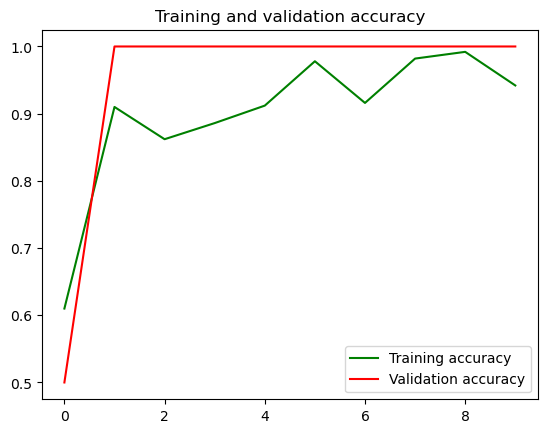

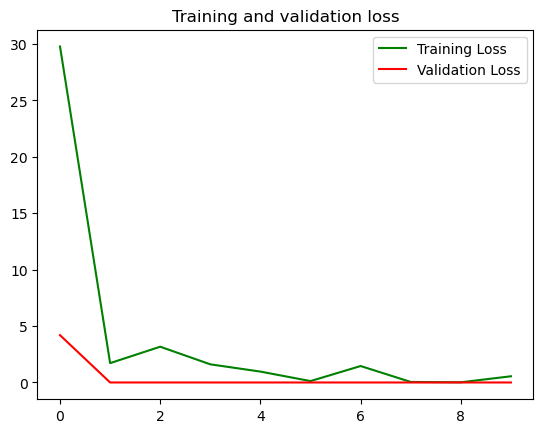

In [7]:
import matplotlib.pyplot as plt
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()